# Simulate a cluster with ocelot

> ⚠ This feature is currently only available for simulating clusters in Gaia DR3 with PARSEC isochrones. More data types will be added soon!

Ocelot includes many utilities for simulating clusters. They are designed to be flexible and 'hackable' for any science case!

Let's quickly demonstrate how it works.

## Setup

Firstly, we'll need to import the relevant parts of the library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia
from ocelot.simulate import (
    SimulatedCluster,
    SimulatedClusterParameters,
    SimulatedClusterModels,
)
from ocelot.simulate.cluster import SimulatedClusterFeatures
from ocelot.model.observation import (
    GaiaDR3ObservationModel,
    GenericSubsampleSelectionFunction,
)

We'll write a little function to plot our clusters:

In [2]:
def plot_on_axes(
    ax, stars: pd.DataFrame, xlabel: str, ylabel: str, scatter_kwargs: dict
):
    ax.scatter(stars[xlabel], stars[ylabel], **scatter_kwargs)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.minorticks_on()


def plot_simulated_cluster(
    cluster: SimulatedCluster | pd.DataFrame, observation: str = None, **kwargs
):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6), dpi=150)
    ax = ax.flatten()

    if observation is None:
        stars = cluster.cluster
        x_cmd = "temperature"
        y_cmd = "luminosity"
        ax[3].invert_xaxis()
        ax[3].set(xscale="log", yscale="log")
    elif observation == "real":
        stars = cluster
        x_cmd = "bp_rp"
        y_cmd = "phot_g_mean_mag"
        ax[3].invert_yaxis()
    else:
        stars = cluster.observations[observation]
        stars["bp_rp"] = stars["gaia_dr3_bp"] - stars["gaia_dr3_rp"]
        x_cmd = "bp_rp"
        y_cmd = "gaia_dr3_g"
        ax[3].invert_yaxis()

    # stars["bp_rp"] = (
    #     stars["phot_bp_mean_mag"] - stars["phot_rp_mean_mag"]
    # )
    scatter_kwargs = dict(s=1, color="k")
    scatter_kwargs.update(kwargs)
    plot_on_axes(ax[0], stars, "l", "b", scatter_kwargs)
    plot_on_axes(ax[1], stars, "pmra", "pmdec", scatter_kwargs)
    plot_on_axes(ax[2], stars, "l", "parallax", scatter_kwargs)
    plot_on_axes(ax[3], stars, x_cmd, y_cmd, scatter_kwargs)
    fig.tight_layout()
    return fig, ax

## Specifying cluster parameters

ocelot stores parameters about a simulated cluster internally with a class called `SimulatedClusterParameters`. You don't have to, but you can specify a new `SimulatedCluster` with this parameter class.

This has the added bonus that the parameters for your cluster are fully type hinted, and get checked when you make them.

To start, your cluster will need a position **with full 3D position and velocity information,** specified as an astropy SkyCoord.

In [3]:
position = SkyCoord(
    ra=45 * u.deg,
    dec=0 * u.deg,
    distance=1000 * u.pc,
    pm_ra_cosdec=10 * u.mas / u.yr,
    pm_dec=0 * u.mas / u.yr,
    radial_velocity=0 * u.km / u.s,
    frame="icrs",
)

We can then plug this position (and other parameters!) into the SimulatedClusterParameters class.

In [4]:
parameters = SimulatedClusterParameters(
    position=position,
    mass=1000,
    log_age=8.0,
    metallicity=0.2,
    extinction=1.0,
    r_core=2,
    r_tidal=10,
    virial_ratio=0.5
)

## A basic simulated cluster

### The most basic possible

ocelot actually tries to simulate clusters to be quite realistic from the get-go. So that we can gradually introduce new functionality, we'll turn some off using a special usually-just-for-testing parameter:

In [5]:
features = SimulatedClusterFeatures(
    binary_stars=False,
    astrometric_uncertainties=False,
    photometric_uncertainties=False,
    selection_effects=False
)

So! Let's simulate a basic cluster. We'll also set a `random_seed` for reproducibility.

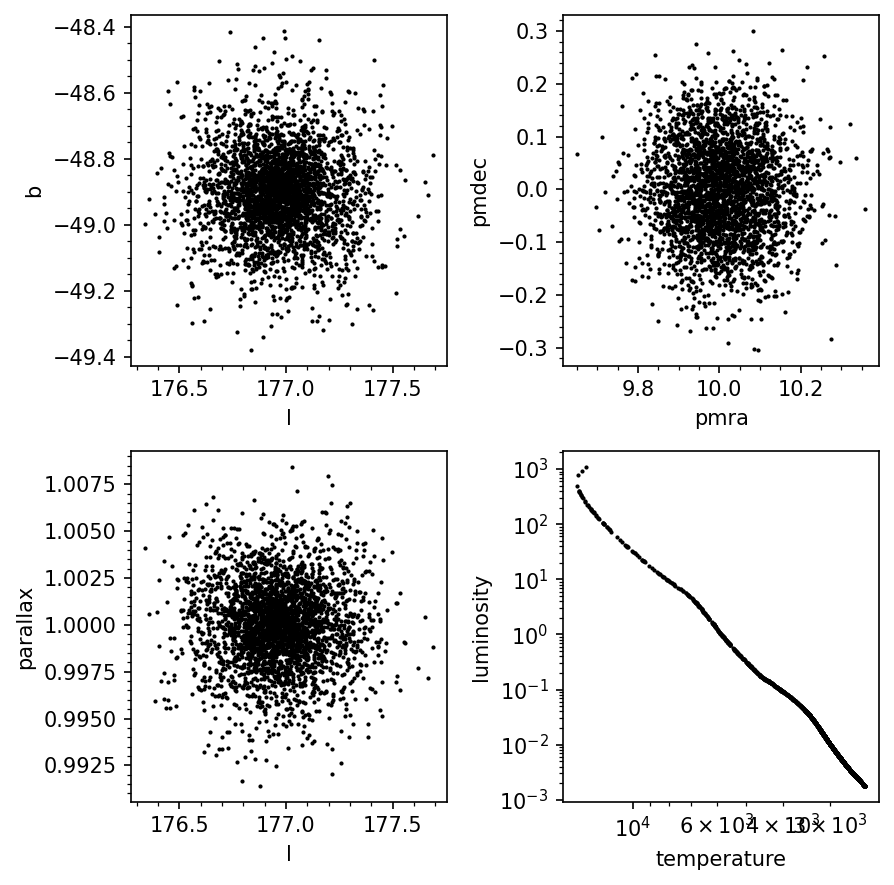

In [6]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters, features=features)
cluster.make()
_ = plot_simulated_cluster(cluster)

This successfully simulates the _true_ positions, luminosities, and temperatures of stars in a simulated cluster that follows a King+62 profile. Great!

The real challenge is to work out what their _observed_ properties would actually be. This requires two more features that are the real chunky parts of `ocelot.simulate`:

1. Pairing stars into binaries
2. Modelling differential extinction
3. Simulating an astrometric & photometric observation.

### Adding in binary stars

Now let's try adding in binary stars.

In [7]:
features = SimulatedClusterFeatures(
    astrometric_uncertainties=False,
    photometric_uncertainties=False,
    selection_effects=False
)

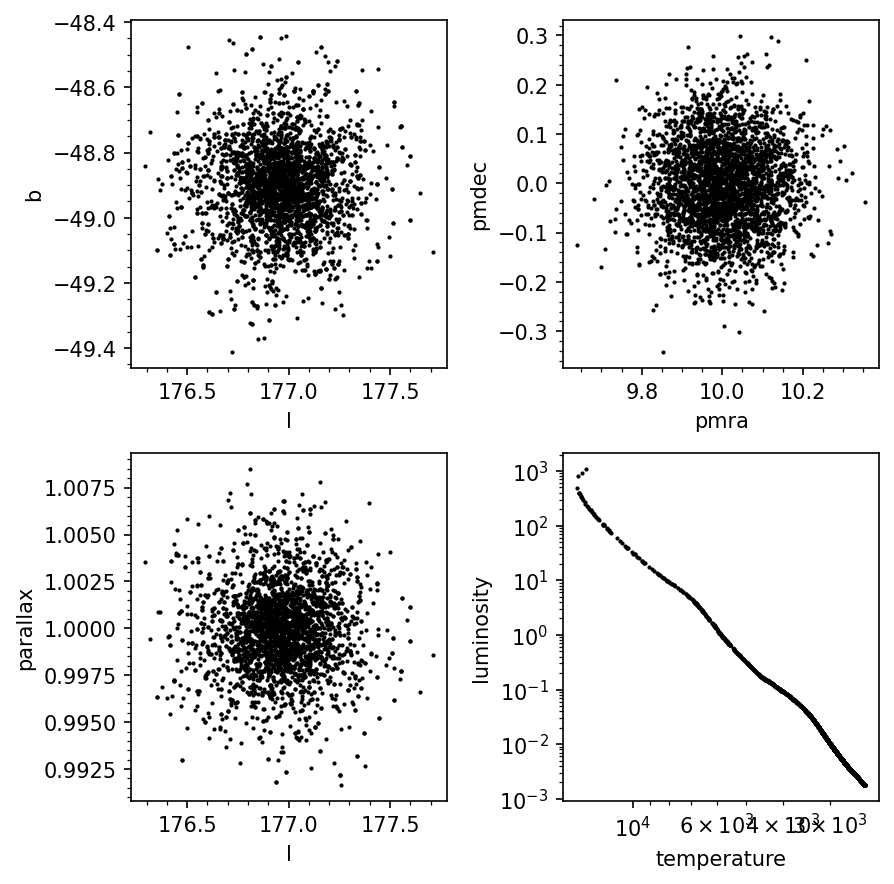

In [8]:
cluster = SimulatedCluster(random_seed=42, parameters=parameters, features=features)
cluster.make()
_ = plot_simulated_cluster(cluster)

Nothing has changed - but behind the scenes, ocelot paired stars in our cluster into binaries. (It takes a bit longer to run the first time, as the code uses `numba` to compile some parts of the binary star code.)

Right now, we're still just viewing an ideal cluster (imagine our telescope has infinite resolving power) - so we don't see and changes in the luminosity-temperature plot on the right.

Nevertheless, many of our stars are now paired into binaries:

In [9]:
cluster.cluster.sample(n=10, random_state=42)[['simulated_id', 'index_primary']]

,simulated_id,index_primary
1241,1088,2456
203,209,2119
1260,1839,2037
1626,2076,-1
1578,1698,-1
102,688,236
2925,2982,-1
1582,857,-1
485,691,-1
1437,1516,2657


For now, just one binary star relation is implemented - the [Moe+17](https://ui.adsabs.harvard.edu/abs/2017ApJS..230...15M/abstract) relationships. ocelot does a lot of fancy stuff to do this - stars are paired together stochastically and placed on random orbits - meaning that binaries are also spatially positioned with their host stars!

The next step is to simulate a real observation with a real telescope.

## Simulating a basic Gaia observation

### Making a cluster look like what a telescope sees

The real power of ocelot comes from how we can simulate what a telescope would see if it looked at a cluster.

Let's simulate a Gaia observation. Currently, we also need a bit of Gaia data to base error, selection etc. effects on around the cluster:

In [10]:
Gaia.ROW_LIMIT = 100000
query = Gaia.cone_search(parameters.position, radius=0.5 * u.deg)
gaia_data = query.get_results().to_pandas().rename(columns={"SOURCE_ID": "source_id"})

We then define a model for our observation and pass this data to `SimulatedCluster.make` - it will handle the rest:

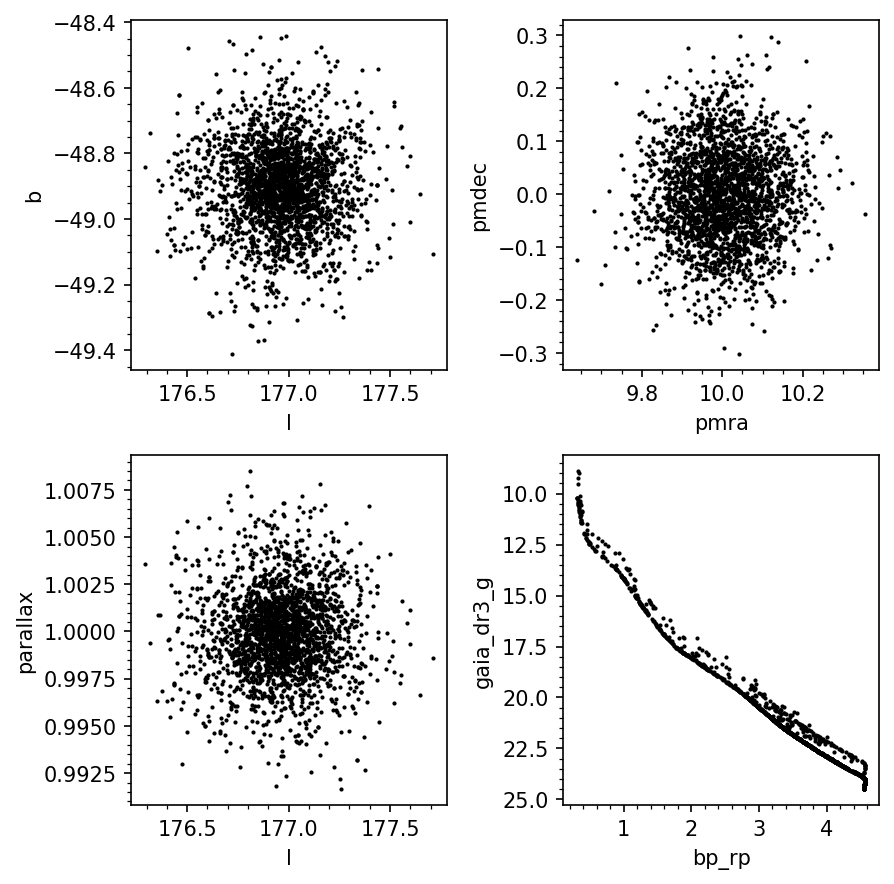

In [11]:
models = SimulatedClusterModels(
    observations=[GaiaDR3ObservationModel(representative_stars=gaia_data)]
)

features = SimulatedClusterFeatures(
    astrometric_uncertainties=False,
    photometric_uncertainties=False,
    selection_effects=False
)

cluster = SimulatedCluster(
    random_seed=42, parameters=parameters, models=models, features=features
)
cluster.make()
_ = plot_simulated_cluster(cluster, observation="gaia_dr3")

Our cluster now has unresolved binary stars and photometry! 

For unresolved binaries - look at the sequence on the right-hand side. This worked by using a (currently somewhat crude) estimate of Gaia's resolving power, and estimating which stars would or wouldn't become binaries.

### Adding uncertainties

Real Gaia data has errors! So we should add uncertainties, too.

Here's what that looks like with errors switched on...

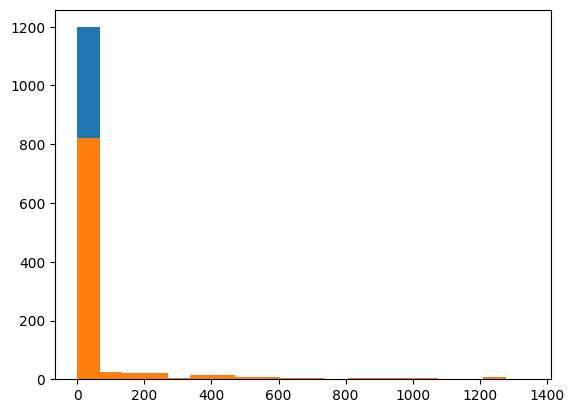

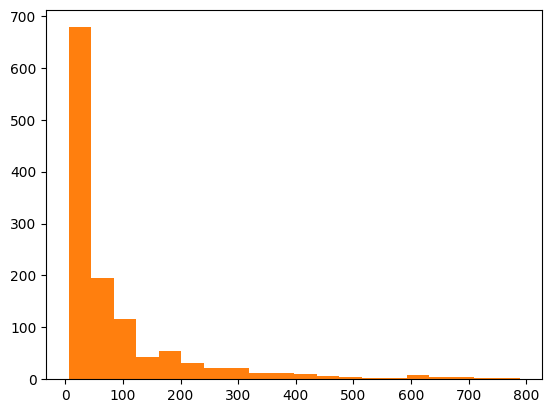

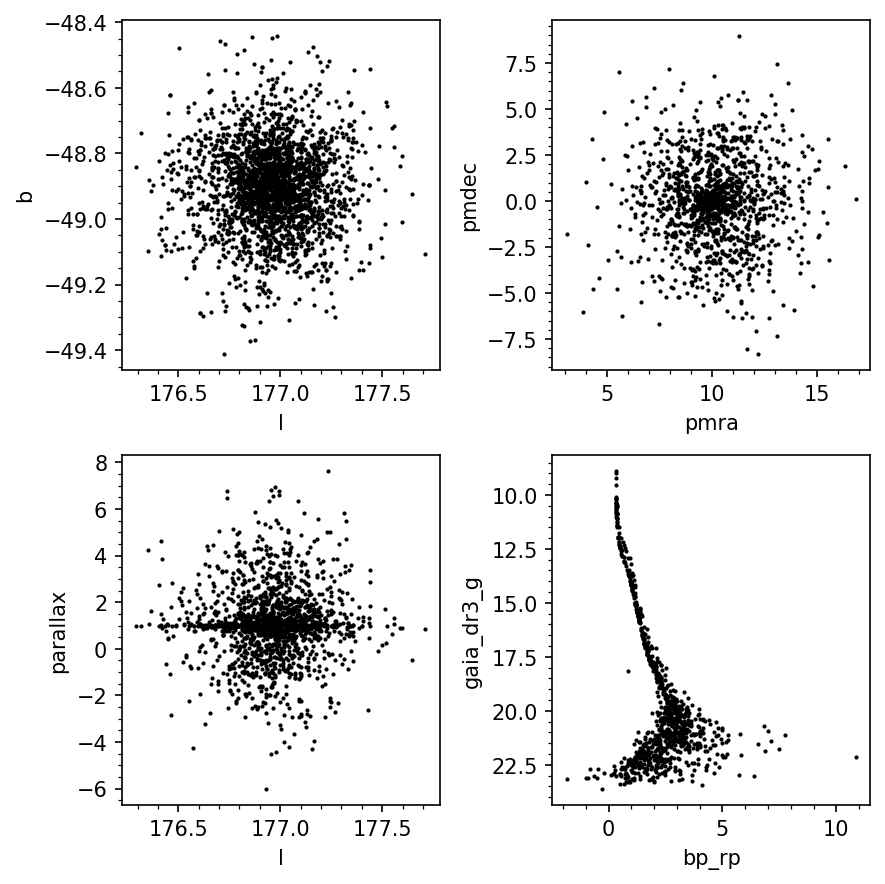

In [12]:
models = SimulatedClusterModels(
    observations=[GaiaDR3ObservationModel(representative_stars=gaia_data)]
)

features = SimulatedClusterFeatures(selection_effects=False)

cluster = SimulatedCluster(
    random_seed=42, parameters=parameters, models=models, features=features
)
cluster.make()
_ = plot_simulated_cluster(cluster, observation="gaia_dr3")

ocelot just used our sample of Gaia data to apply uncertainties to the stars in the cluster. Notice how the cluster now looks _much_ larger in parallaxes and proper motions!

Keen-eyed Gaia users will notice that our cluster continues down to magnitude 25 - far fainter than the Gaia magnitude limit of ~20.7. We should fix that!

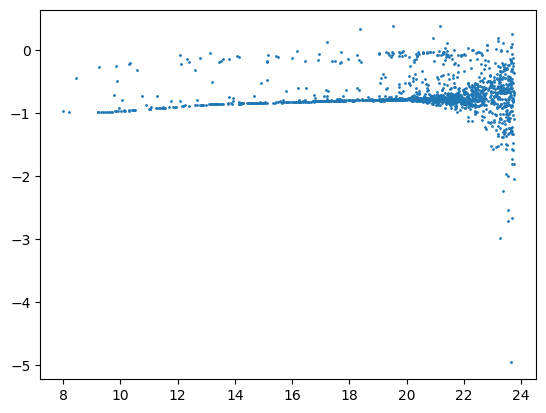

In [15]:
plt.scatter(
    cluster.observations["gaia_dr3"]["gaia_dr3_g_true"],
    cluster.observations["gaia_dr3"]["gaia_dr3_g_true"]
    - cluster.observations["gaia_dr3"]["gaia_dr3_g"],
    s=1
)

### Accounting for selection effects

The final thing to make our cluster a bit more realistic is to apply selection effects.

The Gaia selection function (i.e. a probabilistic magnitude limit) can be applied to our clusters, using the GaiaUnlimited selection function from [Cantat-Gaudin+23](https://ui.adsabs.harvard.edu/abs/2023A%26A...669A..55C/abstract).

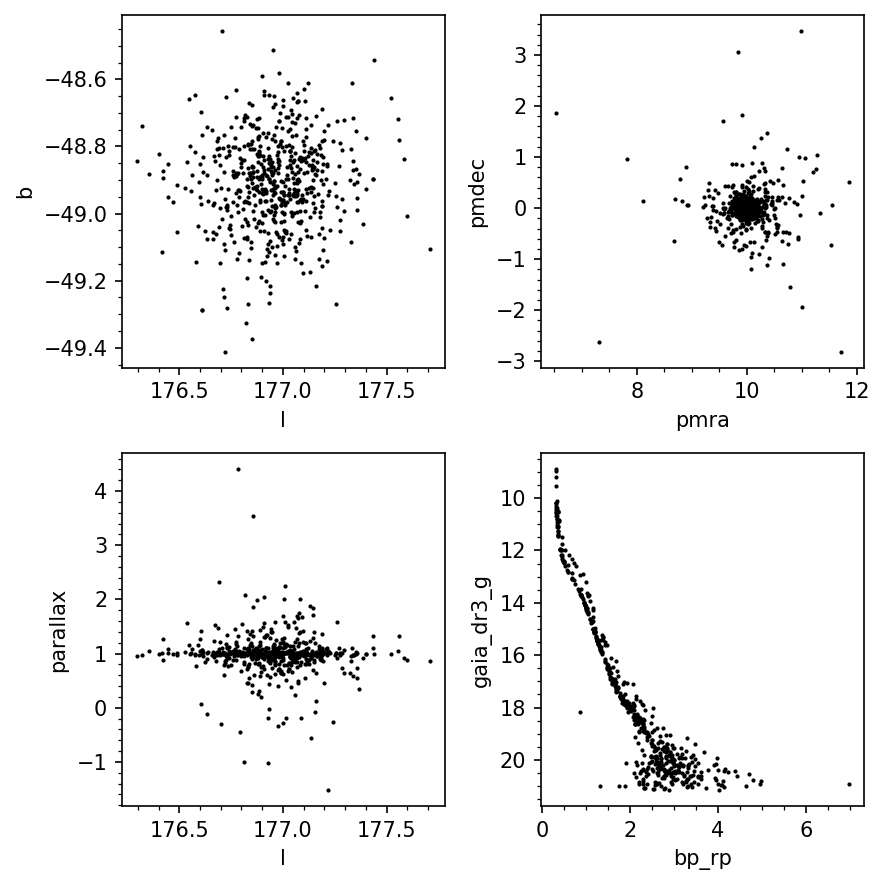

In [13]:
models = SimulatedClusterModels(
    observations=[GaiaDR3ObservationModel(representative_stars=gaia_data)]
)
cluster = SimulatedCluster(random_seed=42, parameters=parameters, models=models)
cluster.make()
_ = plot_simulated_cluster(cluster, observation="gaia_dr3")

Our cluster is now _much_ less populous! There are lots of stars that Gaia can't see.

This is a good place to stop if you're just looking for something really basic! However, ocelot is also able to add on a lot more additional functionality that we'll explore in the rest of this notebook.

## Advanced cluster simulation

### Accounting for subsample selection effects

When working with Gaia data, it's common to do things like cut at a certain magnitude. In addition, many Gaia stars actually don't have proper motions and parallaxes, or have missing photometry in one or more bands. 

It's very common to cut Gaia data to only good samples of stars. ocelot can simulate what a cluster will look like after certain cuts!

Internally, ocelot uses the method from [Rix+21](https://ui.adsabs.harvard.edu/abs/2021AJ....162..142R/abstract) & [Castro-Ginard+23](https://ui.adsabs.harvard.edu/abs/2023A%26A...677A..37C/abstract) to model the probability that a given star would (or would not) be resolved in a subsample of a dataset.

As a simple example, let's define a subset of our Gaia data that contains:

1. Proper motions and parallaxes
2. G, BP, and RP photometry
3. A RUWE (renormalised weight error) greater than 1.4.
4. Only stars greater than magnitude 19.

So that ocelot can simulate this, we need to give it an example subsample of Gaia data. Let's use our region of real data around this cluster from before:

In [14]:
gaia_data_subsample = gaia_data.loc[
    np.logical_and.reduce(
        (
            gaia_data["astrometric_params_solved"] >= 31,
            gaia_data["phot_g_mean_mag"].notna(),
            gaia_data["phot_bp_mean_mag"].notna(),
            gaia_data["phot_rp_mean_mag"].notna(),
            gaia_data["ruwe"] < 1.4,
            gaia_data["phot_g_mean_mag"] < 19,
        )
    )
]
print(
    f"Fraction of stars in subsample: {len(gaia_data_subsample) / len(gaia_data):.2f}"
)

Fraction of stars in subsample: 0.40


Naively, our observed cluster should contain just 40% as many stars - most of which will be at the faint end.

We can make a subsample quite easily, and ocelot has a class for that. We just need to pass it these two dataframes and the key we want to use (in this case, "phot_g_mean_mag" for the data, and "gaia_dr3_g" for the cluster.)

In [15]:
subsample_sf = GenericSubsampleSelectionFunction(
    gaia_data, gaia_data_subsample, "gaia_dr3_g", column_in_data="phot_g_mean_mag"
)

We can even take a quick look at what this selection function looks like.

In [16]:
# Todo make plot

And now, finally, here is our realistic final cluster:

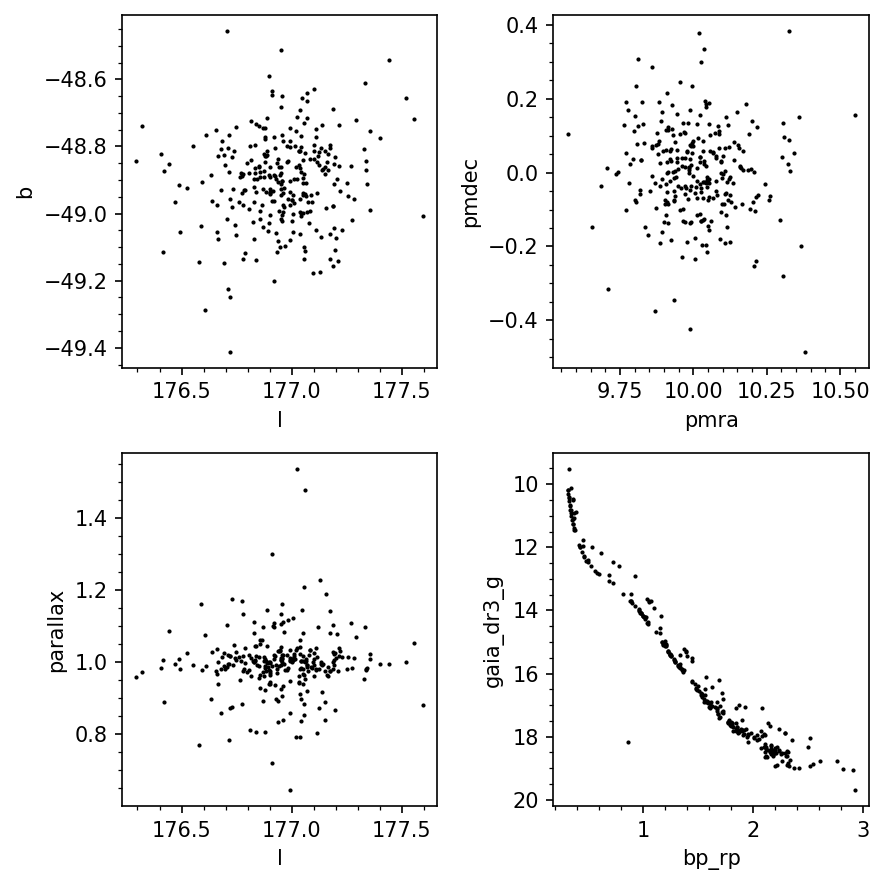

In [17]:
models = SimulatedClusterModels(
    observations=[
        GaiaDR3ObservationModel(
            representative_stars=gaia_data, subsample_selection_functions=[subsample_sf]
        )
    ]
)

cluster = SimulatedCluster(random_seed=42, parameters=parameters, models=models)
cluster.make()
_ = plot_simulated_cluster(cluster, observation="gaia_dr3")

Notice how there are **far fewer stars** than before applying these additional selection effects. In addition, the scatter in proper motion and parallax is a lot lower, as we've removed a lot of faint sources that (if Gaia even could measure their proper motion and parallax) would have very high uncertainty.

Compare it to the full cluster membership list:

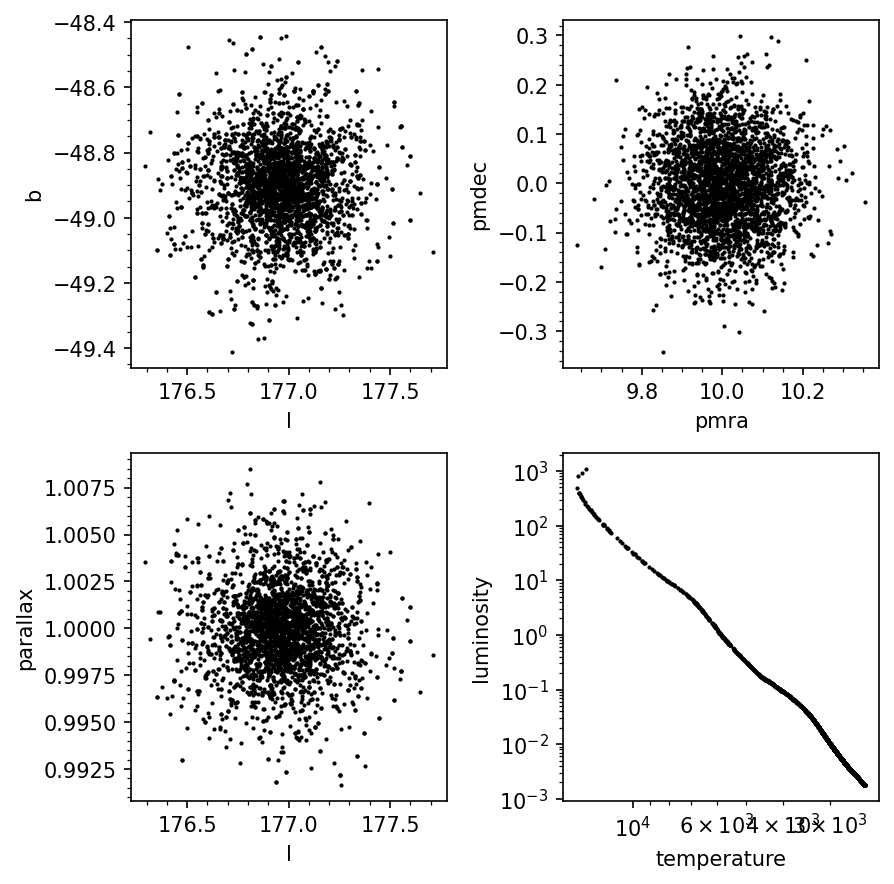

In [18]:
_ = plot_simulated_cluster(cluster)

Unsurprisingly, many stars are missing from Gaia for a cluster that's 1000 parsecs away.

### Differential reddening

Dust in the Milky Way [does not have a simple structure](https://ui.adsabs.harvard.edu/abs/2024A%26A...685A..82E/graphics), and it's rare for a cluster that has extinction to not be _differentially reddened_ to some extent - meaning that some stars have more extinction/reddening than others.

Except for clusters extremely close to the Sun, dust maps are not really precise enough yet to be able to simulate the _exact_ differential reddening across a given cluster. Instead, ocelot provides a way to approximate it with [fractal (pink) noise](https://en.wikipedia.org/wiki/Pink_noise).

This is a feature that has been in our cluster all along - we just need to simulate a cluster with differential reddening enabled!

In [19]:
parameters.differential_extinction = 0.5

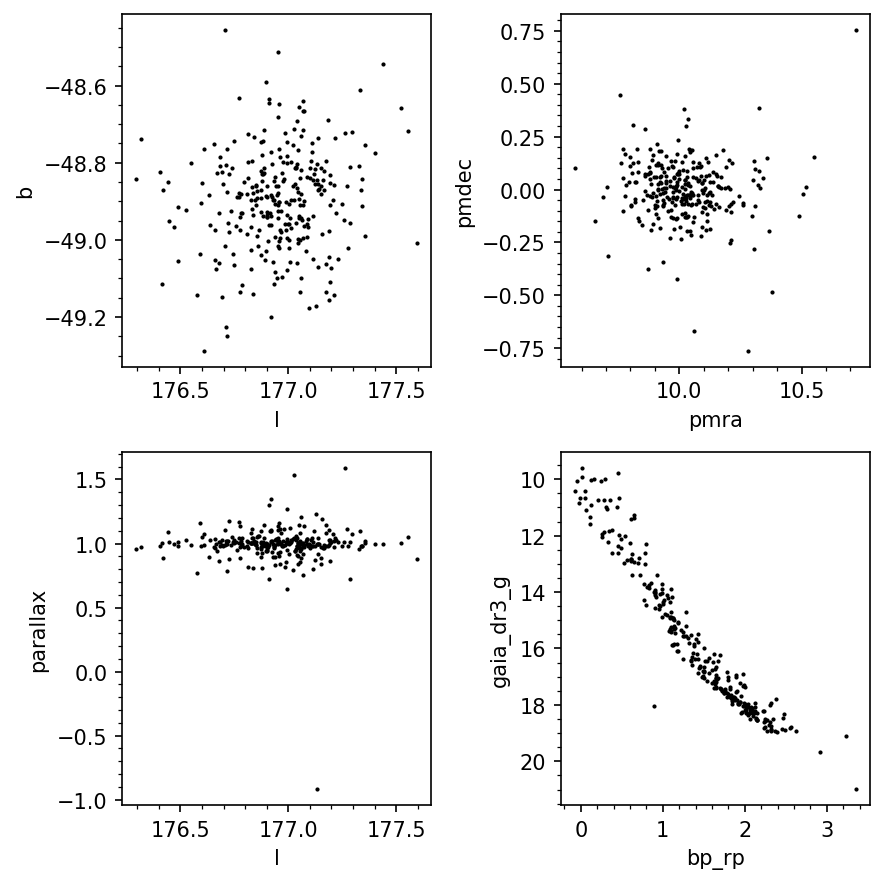

In [20]:
models = SimulatedClusterModels(
    observations=[
        GaiaDR3ObservationModel(
            representative_stars=gaia_data, subsample_selection_functions=[subsample_sf]
        )
    ]
)

cluster = SimulatedCluster(random_seed=42, parameters=parameters, models=models)
cluster.make()
_ = plot_simulated_cluster(cluster, observation="gaia_dr3")

Note how the colour-magnitude diagram of our cluster is now much broader!

It's quite cool to look at what has happened here behind the scenes. Let's plot extinction across the cluster:

[Text(0.5, 0, 'l'), Text(0, 0.5, 'b')]

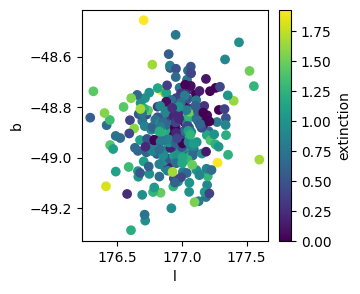

In [21]:
fig, ax = plt.subplots(figsize=(3., 3.))
observation = cluster.observations['gaia_dr3']
points = ax.scatter(observation['l'], observation['b'], c=observation['extinction'])
fig.colorbar(points, label="extinction")
ax.set(xlabel="l", ylabel="b")

We set the differential extinction quite high here for demonstration purposes - but nevertheless, it has clearly added some quite different extinction across the cluster.

Internally, ocelot actually generates a bespoke random fractal noise map depending on the seed we set for the cluster generation:

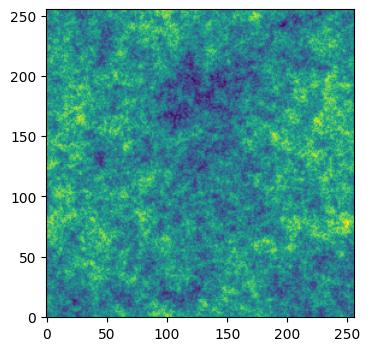

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(cluster.models.differential_reddening._differential_extinction_map, origin="lower")

This noise map ensures that differential reddening across a cluster is **correlated** - meaning one side of the cluster may be more reddened than the other, and we don't just add differential reddening randomly. This can have quite a bit of impact on how well you may see a certain part of a cluster - especially at high differential reddening.

### Simulation pre-pruning

Finally, one thing you can do with ocelot is to 'prune' your simulation of stars.

By default, ocelot simulates all stars in a cluster, and _then_ applies selection effects with your observation. However, if you know you don't care about a certain number of stars that will be invisible anyway (such as very faint ones), then you can 'pre-prune' your cluster and see a noticeable speedup. Here's an example:

Without pruning:

In [23]:
%%timeit
models = SimulatedClusterModels(
    observations=[
        GaiaDR3ObservationModel(
            representative_stars=gaia_data, subsample_selection_functions=[subsample_sf]
        )
    ]
)

cluster = SimulatedCluster(random_seed=42, parameters=parameters, models=models)
cluster.make()

739 ms ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With pruning:

In [24]:
%%timeit
models = SimulatedClusterModels(
    observations=[
        GaiaDR3ObservationModel(
            representative_stars=gaia_data, subsample_selection_functions=[subsample_sf]
        )
    ]
)

cluster = SimulatedCluster(
    random_seed=42,
    parameters=parameters,
    models=models,
    prune_simulated_cluster="gaia_dr3_g_true < 21",
)
cluster.make()

341 ms ± 44.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This can have a **big** impact on more distant clusters, where almost no stars are seen in Gaia.